# Generating and visualizing real-data experiments results in the paper: "Cochlear aqueduct advection and diffusion inferred from computed tomography imaging with a Bayesian approach"

**Note**: This code uses cuqipy version in the branch [enable_FD_NUTS](https://github.com/CUQI-DTU/CUQIpy/tree/enable_FD_NUTS).


In [1]:
import sys
sys.path.append('code/')
import os
from advection_diffusion_inference_utils import (
    all_animals,
    all_ears,
    read_all_real_scenarios,
    plot_inference_real,
    plot_misfit_real,
    matplotlib_setup)
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Run the code to generate the real-data experiments results
You can run the code for the real-data Bayesian inference experiment (presented in figure 3 and 4 in the paper) using the command lines shown below (documentation of the command line arguments can be found in the `README.md` file):

**Note:** Each one of the 20 runs below (10 for advection-diffusion model and 10 for diffusion) takes around 16 hours to complete, in practice, we run them simultaneously, each in a separate job on a cluster.

In [2]:
max_depth = 10 # Depth of the NUTS tree.
Ns = 2000 # Number of samples to draw from the posterior distribution.
Nb = 20 # Number of burn-in samples.

version = "realdata_diff" # Label of the inference, used to distinguish different runs.
sampler = "NUTSWithGibbs" # Sampler to use
unknown_par_type = "constant" # Read the "true" diffusion coefficient" from this file.
unknown_par_value = 100.0 # Value of the diffusion coefficient (not used here since we read it from the file).
data_type = "real" # Type of data to use, here we generate and use synthetic data.
inference_type = "heterogeneous" # Type of inference to perform, here we use heterogeneous to infer spatially varying diffusion coefficients.
num_CA = 5 # Number of CA data points to use, was set to 5 in the paper.
num_ST = 0 # Number of ST data points to use, was set to 0 in the paper.
rbc = "fromDataClip" # Use real data to set the right boundary conditions (clipping the negative values to zero).
noise_level = "0.2" # Noise level of the synthetic data, (not used here because we use real data and noise level is inferred from gibbs sampling).
true_a = 0.0 # True advection coefficient.

# Lambda function to generate the command for running the inference script.
command_function = lambda animal, ear, inference_type: \
f"""
python code/advection_diffusion_inference.py -animal {animal} -ear {ear} -version {version} -sampler {sampler} -unknown_par_type {unknown_par_type} -unknown_par_value {unknown_par_value} -data_type {data_type} -inference_type {inference_type} -Ns {Ns} -Nb {Nb} -noise_level {noise_level} -num_CA {num_CA} -num_ST {num_ST} -true_a {true_a} -rbc {rbc} -NUTS_kwargs '{{"max_depth": {max_depth}, "step_size": 0.1}}' --data_grad  --sampler_callback  --adaptive --u0_from_data"""

# Diffusion inference cases run
all_animals_list = all_animals()
all_ears_list = all_ears()
for animal in all_animals_list:
    for ear in all_ears_list:
        # Command to run the inference script
        command = command_function(animal, ear, inference_type)
        # Run the command
        #!{command} # commented out to avoid running it automatically since it takes long time to run
diffusion_tag = f"{sampler}_{unknown_par_type}_{unknown_par_value}_{data_type}_{inference_type}_{Ns}_{noise_level}_{version}__{num_ST}_{num_CA}_{true_a}_{rbc}"


# Advection-diffusion inference cases run
inference_type = "advection_diffusion" # Type of inference to perform, here we infer both advection and diffusion coefficients.
for animal in all_animals_list:
    for ear in all_ears_list:
        # Command to run the inference script
        command = command_function(animal, ear, "advection_diffusion")
        # Run the command
        #!{command} # commented out to avoid running it automatically since it takes long time to run
advection_diffusion_tag = f"{sampler}_{unknown_par_type}_{unknown_par_value}_{data_type}_{inference_type}_{Ns}_{noise_level}_{version}__{num_ST}_{num_CA}_{true_a}_{rbc}"

## Read the results and visualize it (Figure 3 and 4 in the paper)

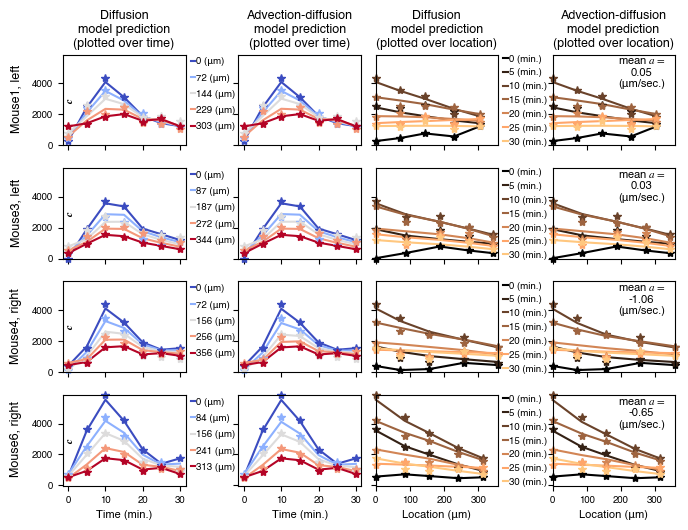

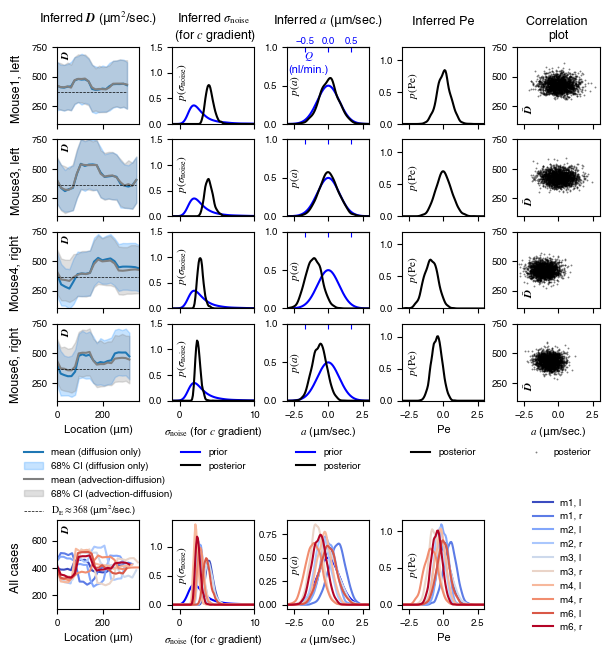

In [3]:
results_directory = 'results/'
tag_list = [version, version, diffusion_tag, advection_diffusion_tag]
animal_ear = [
    ('m1', 'l'),
    ('m3', 'l'),
    ('m4', 'r'),
    ('m6', 'r')
    ]

all_animals_ears = []

for animal in all_animals():
    for ear in all_ears():
        all_animals_ears.append((animal, ear))
data_diff_list, data_adv_list = read_all_real_scenarios(results_directory, tag_list, animal_ear)
data_diff_list_all, data_adv_list_all = read_all_real_scenarios(results_directory, tag_list, all_animals_ears)

# Create plots directory 
if not os.path.exists(f'figures/{version}'):
    os.makedirs(f'figures/{version}')

colormaps = [plt.colormaps.get_cmap('coolwarm'),
             plt.colormaps.get_cmap('copper')]


misfit_info_1 = plot_misfit_real( data_diff_list, data_adv_list, colormaps=colormaps)
plt.savefig(f'figures/{version}/{version}_fig_real_misfit.pdf', bbox_inches='tight') 


all_samples_a = plot_inference_real( data_diff_list, data_adv_list, data_diff_list_all, data_adv_list_all)
# save figure and remove white space
plt.savefig(f'figures/{version}/{version}_fig_real_inference.pdf', bbox_inches='tight')


## Appendix figures (A3, A4 and A5)

In [4]:
animal_ear_rest = np.array([i  for i, case in enumerate(all_animals_ears) if case not in animal_ear ])

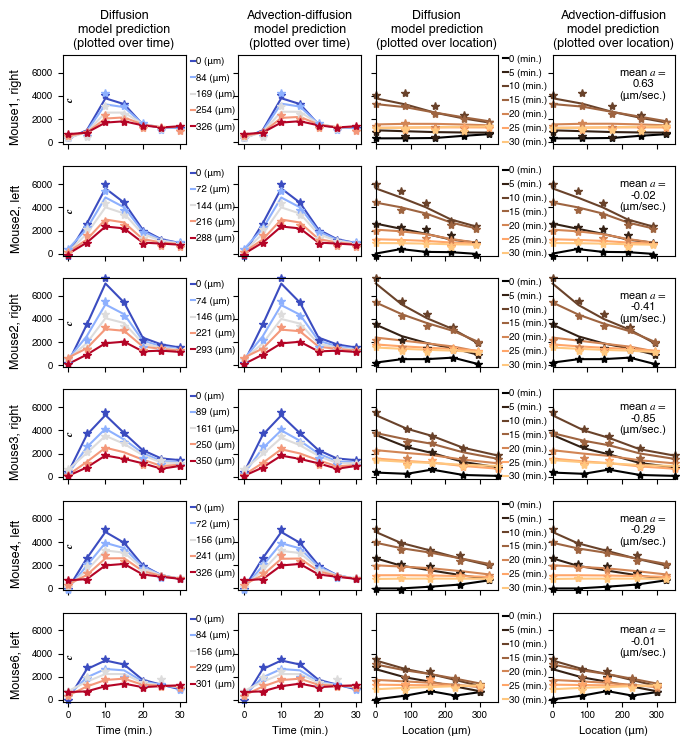

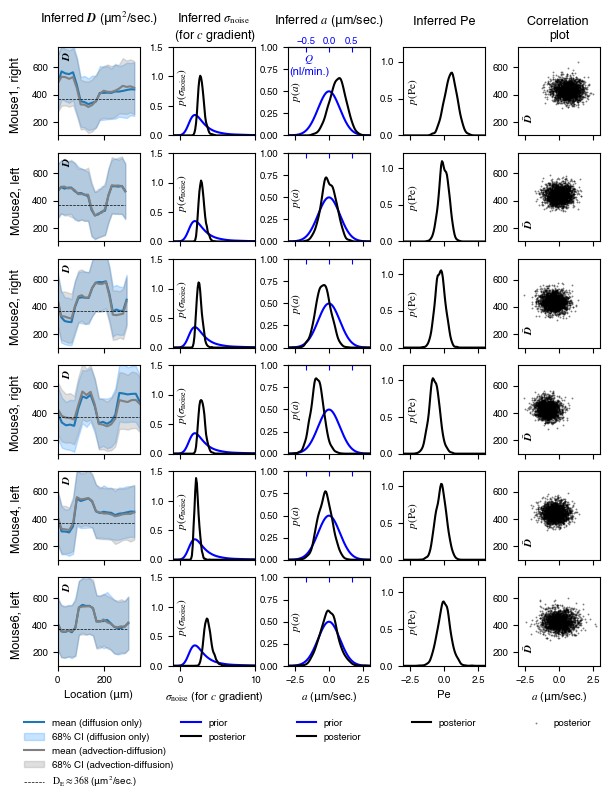

In [5]:
data_diff_list_rest = [data_diff_list_all[i] for i in animal_ear_rest]
data_adv_list_rest = [data_adv_list_all[i] for i in animal_ear_rest]

misfit_info_2 = plot_misfit_real(data_diff_list_rest, data_adv_list_rest, colormaps=colormaps)
plt.savefig('figures/'+version+'/'+version+'_fig_real_misfit_rest.pdf', bbox_inches='tight')

all_samples_a = plot_inference_real( data_diff_list_rest, data_adv_list_rest, data_diff_list_all, data_adv_list_all, add_last_row=False)
plt.savefig('figures/'+version+'/'+version+'_fig_real_inference_rest.pdf', bbox_inches='tight')

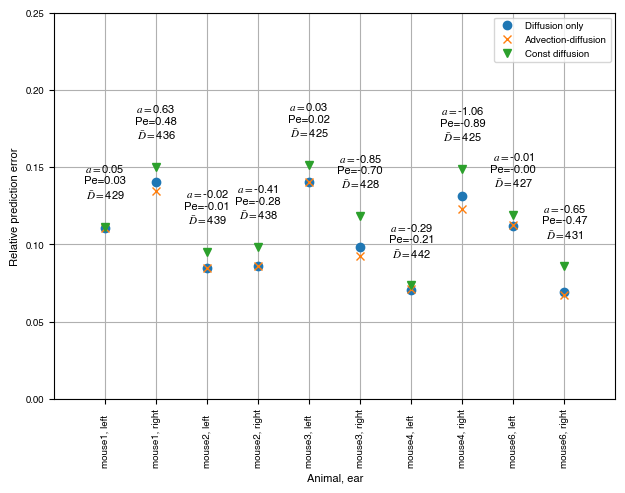

In [6]:
SMALL_SIZE = 7
MEDIUM_SIZE =8
BIGGER_SIZE = 9
matplotlib_setup(SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE)

misfit_data = []
misfit_data.extend(misfit_info_1.split("\n")[1:-1])
misfit_data.extend(misfit_info_2.split("\n")[1:-1])
misfit_data

# reorder 
misfit_data.sort()

fig = plt.figure(figsize=(0.9*7, 0.9*6))
plt.plot([float(row.split(',')[1]) for row in misfit_data], label='Diffusion only', marker='o', linestyle='None')
plt.plot([float(row.split(',')[2]) for row in misfit_data], label='Advection-diffusion', marker='x', linestyle='None')
plt.plot([float(row.split(',')[3]) for row in misfit_data], label='Const diffusion', marker='v', linestyle='None')
D_bar_list = [float(row.split(',')[4]) for row in misfit_data]
speed = [float(row.split(',')[5]) for row in misfit_data]
Pect_list = [float(row.split(',')[6]) for row in misfit_data]
for x_loc, y_loc in enumerate([float(row.split(',')[3]) for row in misfit_data]):
    plt.annotate(
                 r"$a=$"+f"{speed[x_loc]:.2f}\n"+
                 "Pe="+f"{Pect_list[x_loc]:.2f}\n"+
                 r"$\bar{D}=$"+f"{D_bar_list[x_loc]:.0f}",
                 (x_loc, y_loc), textcoords="offset points", xytext=(0,20), ha='center', fontsize=8)
plt.xticks(ticks=range(len(misfit_data)), labels=[row.split(',')[0].replace('-',', ') for row in misfit_data], rotation=90)
plt.xlabel("Animal, ear")
plt.ylabel("Relative prediction error")
plt.grid()
plt.tight_layout()
plt.ylim([0.0, 0.25])
plt.xlim([-1, len(misfit_data)])
plt.legend()
plt.savefig('figures/'+version+'/'+version+'_fig_real_misfit_summary.pdf', bbox_inches='tight')